# nanoGPT – Quick Training Notebook

Use this notebook to run a short training loop on Tiny Shakespeare (character-level).

Workflow:
1) Run "Setup" to detect device and branch.
2) Run "Prepare data" once (creates `data/shakespeare_char/train.bin`, `val.bin`).
3) Run "Train" to see losses (train/val) for a very short run.
4) If you edit `model.py`, rerun the "Reload model & Rebuild" cell to pick up changes (module reload).

Configuration:
- Small model (4 layers, 4 heads, 128 embedding dim)
- Fast training (300 iterations)
- No DDP, no `torch.compile` for simplicity



In [1]:
# Setup: imports, device, utils
from __future__ import annotations

import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import subprocess
import pickle
import time
import sys

import torch

# Ensure repository root on sys.path
repo_root = Path.cwd()
if str(repo_root) not in sys.path:
    sys.path.append(str(repo_root))


def detect_device() -> str:
    if torch.cuda.is_available():
        return "cuda"
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        return "mps"
    return "cpu"


def current_branch() -> str:
    try:
        out = subprocess.check_output(
            ["git", "rev-parse", "--abbrev-ref", "HEAD"], cwd=repo_root
        )
        return out.decode().strip()
    except Exception:
        return "unknown"


def checkout_branch(name: str) -> None:
    """Optionally switch branches from within the notebook, then reload model in a later cell."""
    subprocess.check_call(["git", "checkout", name], cwd=repo_root)
    print(f"Switched to branch: {name}")


device = detect_device()
torch.manual_seed(1337)
print(f"Device: {device}")
print(f"Git branch: {current_branch()}")

# Plot style
plt.style.use("ggplot")

Device: mps
Git branch: interview-kvcache-solution


In [2]:
# Package import (now that we've updated sys.path)
from model import GPTConfig, GPT

# Prepare data: Tiny Shakespeare (character-level)
DATA_DIR = repo_root / "data" / "shakespeare_char"
TRAIN_BIN = DATA_DIR / "train.bin"
VAL_BIN = DATA_DIR / "val.bin"

if TRAIN_BIN.exists() and VAL_BIN.exists():
    print("Tiny Shakespeare binaries already exist.")
    print(f"- {TRAIN_BIN}")
    print(f"- {VAL_BIN}")
else:
    print(
        "Preparing Tiny Shakespeare dataset (this downloads ~1MB and preprocesses)..."
    )
    subprocess.check_call([sys.executable, str(DATA_DIR / "prepare.py")], cwd=repo_root)
    assert TRAIN_BIN.exists() and VAL_BIN.exists(), (
        "Data preparation failed to produce train.bin/val.bin"
    )
    print("Done.")

Tiny Shakespeare binaries already exist.
- /Users/darienschettler/PycharmProjects/nanoGPT-1/data/shakespeare_char/train.bin
- /Users/darienschettler/PycharmProjects/nanoGPT-1/data/shakespeare_char/val.bin


In [3]:
# Training utilities: tiny config & dataloader
# Small, fast config suitable for CPU/MPS/GPU
block_size = 512
batch_size = 16
n_layer = 4
n_head = 4
n_embd = 128
dropout = 0.0
max_iters = 5_000
log_interval = 10
eval_interval = 100
eval_iters = 25
learning_rate = 3e-4
weight_decay = 0.1

# Use KV-cache during sampling/generation
use_kv_cache_in_generation = True

# Dataloader: same shape semantics as train.py
DATA_MEM_TRAIN = str(TRAIN_BIN)
DATA_MEM_VAL = str(VAL_BIN)


def get_batch(split: str) -> tuple[torch.Tensor, torch.Tensor]:
    data = np.memmap(
        DATA_MEM_TRAIN if split == "train" else DATA_MEM_VAL, dtype=np.uint16, mode="r"
    )
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack(
        [torch.from_numpy((data[i : i + block_size]).astype(np.int64)) for i in ix]
    )
    y = torch.stack(
        [
            torch.from_numpy((data[i + 1 : i + 1 + block_size]).astype(np.int64))
            for i in ix
        ]
    )
    x, y = x.to(device), y.to(device)
    return x, y


@torch.no_grad()
def estimate_loss(model) -> dict[str, float]:
    model.eval()
    out = {}
    for split in ["train", "val"]:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss, _ = model(
                X, Y
            )  # Unpack 3 values (cache is None during training)
            losses[k] = loss.item()
        out[split] = losses.mean().item()
    model.train()
    return out

In [4]:
# Reload model & Rebuild (run this after switching branches or editing model.py)
import importlib
import model as model_module

importlib.reload(model_module)
print(f"Using model from: {model_module.__file__}")

# Infer vocab size from dataset meta if present, fallback to GPT-2 padded size
meta_path = DATA_DIR / "meta.pkl"
meta_vocab_size = None
if meta_path.exists():
    with open(meta_path, "rb") as f:
        meta = pickle.load(f)
    meta_vocab_size = int(meta.get("vocab_size", 50304))

vocab_size = meta_vocab_size if meta_vocab_size is not None else 50304

cfg = GPTConfig(
    block_size=block_size,
    vocab_size=vocab_size,
    n_layer=n_layer,
    n_head=n_head,
    n_embd=n_embd,
    dropout=dropout,
    bias=True,
)
model = GPT(cfg).to(device)
optimizer = torch.optim.AdamW(
    model.parameters(), lr=learning_rate, weight_decay=weight_decay
)

print("Model built.")

Using model from: /Users/darienschettler/PycharmProjects/nanoGPT-1/model.py
number of parameters: 0.80M
Model built.


[init] train loss: 4.2140, val loss: 4.2093
iter   10 | loss 3.4049
iter   20 | loss 3.1388
iter   30 | loss 2.9821
iter   40 | loss 2.8805
iter   50 | loss 2.7761
iter   60 | loss 2.7256
iter   70 | loss 2.6909
iter   80 | loss 2.6699
iter   90 | loss 2.6287
iter  100 | loss 2.6179
[eval] iter  100 | train 2.6147 | val 2.6215
iter  110 | loss 2.6159
iter  120 | loss 2.6061
iter  130 | loss 2.5671
iter  140 | loss 2.5651
iter  150 | loss 2.5595
iter  160 | loss 2.5575
iter  170 | loss 2.5649
iter  180 | loss 2.5283
iter  190 | loss 2.5323
iter  200 | loss 2.5319
[eval] iter  200 | train 2.5178 | val 2.5337
iter  210 | loss 2.5039
iter  220 | loss 2.5406
iter  230 | loss 2.5027
iter  240 | loss 2.5025
iter  250 | loss 2.4771
iter  260 | loss 2.5276
iter  270 | loss 2.4747
iter  280 | loss 2.4890
iter  290 | loss 2.4981
iter  300 | loss 2.4728
[eval] iter  300 | train 2.4854 | val 2.4822
iter  310 | loss 2.4728
iter  320 | loss 2.4891
iter  330 | loss 2.4864
iter  340 | loss 2.4599
iter 

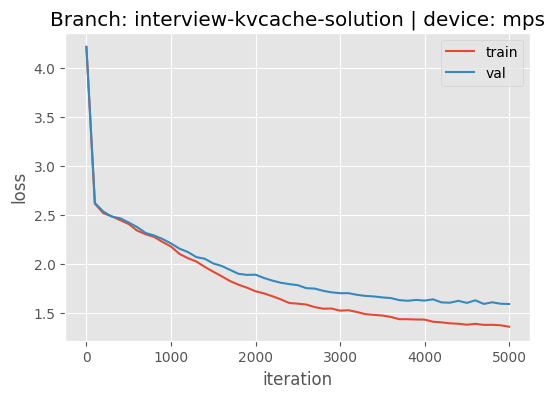

In [5]:
# Train (brief run) and plot
train_losses, val_losses, steps = [], [], []

# Initial eval
losses = estimate_loss(model)
print(f"[init] train loss: {losses['train']:.4f}, val loss: {losses['val']:.4f}")
train_losses.append(losses["train"])
val_losses.append(losses["val"])
steps.append(0)

for it in range(1, max_iters + 1):
    X, Y = get_batch("train")
    # Note: KV-cache is NOT used during training (only during generation)
    # Training always processes full sequences, so cache provides no benefit
    logits, loss, _ = model(X, Y)  # kv_cache=None by default
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()

    if it % log_interval == 0:
        print(f"iter {it:4d} | loss {loss.item():.4f}")

    if it % eval_interval == 0:
        losses = estimate_loss(model)
        print(
            f"[eval] iter {it:4d} | train {losses['train']:.4f} | val {losses['val']:.4f}"
        )
        train_losses.append(losses["train"])
        val_losses.append(losses["val"])
        steps.append(it)

# Plot
plt.figure(figsize=(6, 4))
plt.plot(steps, train_losses, label="train")
plt.plot(steps, val_losses, label="val")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.title(f"Branch: {current_branch()} | device: {device}")
plt.legend()
plt.show()

In [6]:
# Quick sampling helper after training
def sample(
    model,
    start: str = "To be, or",
    max_new_tokens: int = 100,
    temperature: float = 1.0,
    use_kv_cache: bool = True,
) -> str:
    model.eval()
    # Load tokenizer metadata if present (char-level uses simple identity)
    # For Tiny Shakespeare char-level, meta.pkl includes 'itos' / 'stoi'
    import pickle

    meta_path = DATA_DIR / "meta.pkl"
    if not meta_path.exists():
        print("No meta.pkl found; sampling skipped.")
        return ""
    with open(meta_path, "rb") as f:
        meta = pickle.load(f)
    stoi = meta["stoi"]
    itos = meta["itos"]

    def encode(s: str):
        return [stoi[c] for c in s]

    def decode(ids):
        return "".join([itos[i] for i in ids])

    idx = torch.tensor([encode(start)], dtype=torch.long, device=device)
    with torch.no_grad():
        # Use KV-cache for faster generation if enabled
        idx = model.generate(
            idx,
            max_new_tokens=max_new_tokens,
            temperature=temperature,
            use_cache=use_kv_cache,
        )
    return decode(idx[0].tolist())

TOKENS_TO_GENERATE = 500
TEMPERATURE = 0.7

print(f"\n{'=' * 80}")
print(f"WITH CACHE:\n{'=' * 80}\n")
t1 = time.time()
print(sample(model, start="ROMEO:", max_new_tokens=TOKENS_TO_GENERATE, temperature=TEMPERATURE, use_kv_cache=use_kv_cache_in_generation))
print(f"\n{'=' * 80}")
print(time.time() - t1)
print(f"{'=' * 80}")

print(f"\n{'=' * 80}\n\n{'=' * 80}\nWITHOUT CACHE:\n{'=' * 80}\n")
t1 = time.time()
print(sample(model, start="ROMEO:", max_new_tokens=TOKENS_TO_GENERATE, temperature=TEMPERATURE, use_kv_cache=False))
print(f"\n{'=' * 80}")
print(time.time() - t1)
print(f"{'=' * 80}")


WITH CACHE:

ROMEO:
Nay, my lord, what strengt upon in him.

HENRY BOLINGBROKE:
My lord, commend not be neither thy scales;
And make thy battle our free with shall call thee
This back thy endure both all strength here;
To lose and thou art hope thy band him.

FRIAR LAURENCE:
Mercy:
Thoughn you are good death a did till there wind
Commend with heavens himself that thy lord.

VIRGILIA:
Now, let's be change as well, and to preplected.

BALTHASAR:
Yet ready to shall be so my deed hear brothers
And and contrary in to h

7.841362237930298


WITHOUT CACHE:

ROMEO:
Alas, and death! he liege to me, nor he is charged on
And yet her he such to bear preserve him of the lead
And clibured fatal roses entrainess mong from myself:
And my sole not army did should and with me
Commonist pity be Siciliam let the not may ext
As in Couris himself of me but with inche,
And she only to much maid the endure means
That of all so hope to the state,
Come, come the peacer's with and scould court
And my mannary fr